In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
# Training Parameters
LEARNING_RATE = 0.005
TRAINING_STEP = 5000
DISPLAY_STEP = 100

# Network Parameters
NUM_INPUT = 3
NUM_OUTPUT = 1
TIME_STEPS = 24
NUM_HIDDEN = [32,]  # hidden layer num of features

In [3]:
# Pre-process data
d_X = pd.read_csv('./data/X.csv').values
d_Y = pd.read_csv('./data/Y.csv').values
scaler_X = preprocessing.MinMaxScaler()
scaler_Y = preprocessing.MinMaxScaler()
d_X = scaler_X.fit_transform(d_X)
d_Y = scaler_Y.fit_transform(d_Y)

In [4]:
# Change data format
TOTAL_DAYS = 365
data_X = np.zeros((TOTAL_DAYS, TIME_STEPS, NUM_INPUT))
data_Y = np.zeros((TOTAL_DAYS, TIME_STEPS, NUM_OUTPUT))
for i in range(TOTAL_DAYS):
    data_X[i, :, :] = d_X[i * TIME_STEPS:(i + 1) * TIME_STEPS, :]
    data_Y[i, :, :] = d_Y[i * TIME_STEPS:(i + 1) * TIME_STEPS, 0:NUM_OUTPUT]

In [5]:
# 1 2   3    4    5    6    7    8    9    10   11   12
# 0 31  59   90   120  151  181  212  243  274  304  334 365
TRAIN_DAY_START = 0
TRAIN_DAY_END = 274
TEST_DAY_START = TRAIN_DAY_END
TEST_DAY_END = TOTAL_DAYS

# Split data into train and test, Nov and Dec used as test data
data_X_train = data_X[TRAIN_DAY_START:TRAIN_DAY_END, :, :]
data_Y_train = data_Y[TRAIN_DAY_START:TRAIN_DAY_END, :, :]
data_X_test = data_X[TEST_DAY_START:TEST_DAY_END, :, :]
data_Y_test = data_Y[TEST_DAY_START:TEST_DAY_END, :, :]

In [6]:
def build_RNN():
    # tf Graph input
    X = tf.placeholder('float', [None, TIME_STEPS, NUM_INPUT])
    Y = tf.placeholder('float', [None, TIME_STEPS, NUM_OUTPUT])

    # Create 1 layer that consists of RNNCells
    rnn_layers = [tf.nn.rnn_cell.GRUCell(size) for size in NUM_HIDDEN]

    # Create a RNN cell composed sequentially of a number of RNNCells
    multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)

    # 'outputs' is a tensor of shape [batch_size, TIME_STEPS, NUM_HIDDEN[-1]]
    # 'state' is a N-tuple where N is the number of LSTMCells containing a
    # tf.contrib.rnn.LSTMStateTuple for each cell
    outputs, state = tf.nn.dynamic_rnn(cell=multi_rnn_cell, inputs=X, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    W_out = tf.get_variable('W_out', shape=(NUM_HIDDEN[-1], NUM_OUTPUT),
                            initializer=tf.contrib.layers.xavier_initializer())
    b_out = tf.get_variable('b_out', shape=NUM_OUTPUT,
                            initializer=tf.zeros_initializer())
    # logits = tf.contrib.layers.fully_connected(inputs=outputs[:, -1, :], num_outputs=NUM_OUTPUT, activation_fn=None)
    logits = []
    for i in range(TIME_STEPS):  # TIME_STEPS
        output = tf.add(tf.matmul(outputs[:, i, :], W_out), b_out)
        logits.append(output)
    logits = tf.stack(logits, axis=1)
    
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.losses.mean_squared_error(predictions=logits, labels=Y))
    train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss_op)
    
    return X, Y, logits, loss_op, train_op


# Bulid RNN network
X, Y, logits, loss_op, train_op = build_RNN()

In [7]:
# Add ops to save and restore all the variables
saver = tf.train.Saver()
model_path = './models/price_model'

# Train
with tf.Session() as sess:
    # Run the initializer
    sess.run(tf.global_variables_initializer())

    for step in range(TRAINING_STEP):
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: data_X_train, Y: data_Y_train})
        if step % DISPLAY_STEP == 0:
            # Calculate loss
            loss = sess.run(loss_op, feed_dict={X: data_X_train, Y: data_Y_train})
            print('Step ' + str(step) + ', Minibatch Loss= ' + '{:.6f}'.format(loss))

    print('Training completed!')
    # save the model
    save_path = saver.save(sess, model_path)
    print('Model saved in file {}'.format(save_path))


Step 0, Minibatch Loss= 0.010016
Step 100, Minibatch Loss= 0.001013
Step 200, Minibatch Loss= 0.000865
Step 300, Minibatch Loss= 0.000823
Step 400, Minibatch Loss= 0.000802
Step 500, Minibatch Loss= 0.000785
Step 600, Minibatch Loss= 0.000771
Step 700, Minibatch Loss= 0.000757
Step 800, Minibatch Loss= 0.000741
Step 900, Minibatch Loss= 0.000719
Training completed!
Model saved in file ./models/price_model


In [8]:
# Test
with tf.Session() as sess:
    # Restore model weights from previously saved model
    load_path = saver.restore(sess, model_path)
    print('Model restored from file {}'.format(load_path))

    # Evaluate training/test data
    loss_train, pred_train = sess.run([loss_op, logits], feed_dict={X: data_X_train, Y: data_Y_train})
    loss_test, pred_test = sess.run([loss_op, logits], feed_dict={X: data_X_test, Y: data_Y_test})


INFO:tensorflow:Restoring parameters from ./models/price_model
Model restored from file None


In [9]:
# Compute train error
data_Y_train = data_Y_train.ravel()
data_Y_train = data_Y_train * (scaler_Y.data_max_[0] - scaler_Y.data_min_[0]) + scaler_Y.data_min_[0]
pred_train = pred_train.ravel()
pred_train = pred_train * (scaler_Y.data_max_[0] - scaler_Y.data_min_[0]) + scaler_Y.data_min_[0]
error_train = np.abs(pred_train - data_Y_train)
print('Train error: mean--{:.2f}, std--{:.2f}'.format(np.mean(error_train), np.std(error_train)))

# Compute test error
data_Y_test = data_Y_test.ravel()
data_Y_test = data_Y_test * (scaler_Y.data_max_[0] - scaler_Y.data_min_[0]) + scaler_Y.data_min_[0]
pred_test = pred_test.ravel()
pred_test = pred_test * (scaler_Y.data_max_[0] - scaler_Y.data_min_[0]) + scaler_Y.data_min_[0]
error_test = np.abs(pred_test - data_Y_test)
print('Test error: mean--{:.2f}, std--{:.2f}'.format(np.mean(error_test), np.std(error_test)))


Train error: mean--7.55, std--14.17
Test error: mean--5.51, std--8.40


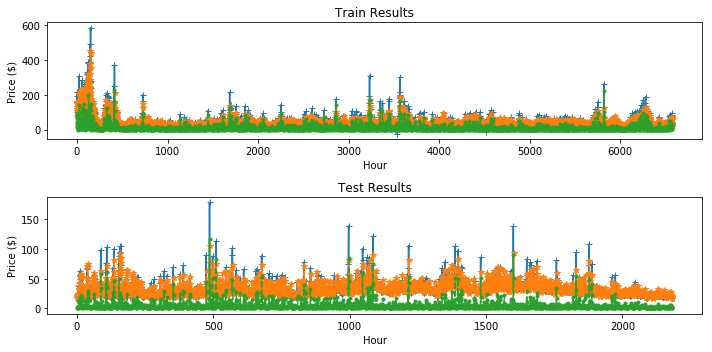

In [10]:
# Plot results as time series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
axes[0].plot(data_Y_train, marker='+', ls='-')
axes[0].plot(pred_train, marker='*', ls='--')
axes[0].plot(error_train, marker='.', ls='--')
axes[0].set(xlabel='Hour', ylabel='Price ($)', title='Train Results')

axes[1].plot(data_Y_test, marker='+', ls='-')
axes[1].plot(pred_test, marker='*', ls='--')
axes[1].plot(error_test, marker='.', ls='--')
axes[1].set(xlabel='Hour', ylabel='Price ($)', title='Test Results')
plt.tight_layout()
plt.show()
